In [1]:
import time 
t_script = time.time()

### Load libraries, functions, palette, theme

In [180]:
%run __libraries.ipynb

In [183]:
%run __functions.ipynb

### Load Saved Section if exists

In [4]:
dir_save = '04-Models-Comparison'

## Models Comparison

In [5]:
colors = [
    palette[1],
    palette[2],
    palette[-7],
    palette[-9],
    palette[-1]
]

In [6]:
models_list = [
    'Logistic Regression',
    'Random Forest',
    'XGBoost',
    'LightGBM'
]

In [7]:
metrics = [
    'AUC ROC',
    'Average Precision',
    'Card Precision@100'
]

### Features Selection

In [8]:
features = [
    'tx_amount', 'tx_during_weekend', 'tx_during_night',
    'customer_id_nb_tx_1day_window', 'customer_id_avg_amount_1day_window',
    'customer_id_nb_tx_7day_window', 'customer_id_avg_amount_7day_window',
    'customer_id_nb_tx_30day_window', 'customer_id_avg_amount_30day_window',
    'terminal_id_nb_tx_1day_window', 'terminal_id_risk_1day_window',
    'terminal_id_nb_tx_7day_window', 'terminal_id_risk_7day_window',
    'terminal_id_nb_tx_30day_window', 'terminal_id_risk_30day_window'
]

target = 'tx_fraud'

### Load Baseline Results

#### Models

In [9]:
performance_base = pd.read_pickle(r'_performance_base.pkl')
summary_base = pd.read_pickle(r'_summary_base.pkl')
time_exec_base = pd.read_pickle(r'_time_exec_base.pkl')

In [10]:
performance_lr_base = performance_base['Logistic Regression']
performance_rf_base = performance_base['Random Forest']
performance_xgb_base = performance_base['XGBoost']
performance_lgb_base = performance_base['LightGBM']

exec_time_lr_base = time_exec_base['Logistic Regression']
exec_time_rf_base = time_exec_base['Random Forest']
exec_time_xgb_base = time_exec_base['XGBoost']
exec_time_lgb_base = time_exec_base['LightGBM']

#### Hyperparameters

In [11]:
hyper_dict = pd.read_pickle(r'_hyperparameters_base.pkl')

In [12]:
hyper_dict

{'Logistic Regression': {'penalty': 'l2',
  'C': 1,
  'solver': 'saga',
  'max_iter': 5000,
  'random_state': 42},
 'Random Forest': {'n_estimators': 150, 'max_depth': 25, 'random_state': 42},
 'XGBoost': {'n_estimators': 150,
  'max_depth': 3,
  'learning_rate': 0.1,
  'random_state': 42},
 'LightGBM': {'n_estimators': 150,
  'max_depth': 3,
  'learning_rate': 0.1,
  'random_state': 42}}

### Baseline Results

In [13]:
model_performance_list = [
    performance_lr_base, performance_rf_base,
    performance_xgb_base, performance_lgb_base
]

In [14]:
model_exec_time_list = [
    exec_time_lr_base, exec_time_rf_base,
    exec_time_xgb_base, exec_time_lgb_base
]

In [15]:
results = results_df_create(
    models_list, model_performance_list, model_exec_time_list,
    hyper_dict=hyper_dict,
    drop_hyper=1
)

In [16]:
results

,Parameters,AUC ROC,AUC ROC Std,Average Precision,Average Precision Std,Card Precision@100,Card Precision@100 Std,Fit Time,Score Time,Tuning Time
Logistic Regression,l2/1/saga/5000,0.876,0.0178,0.614,0.0277,0.296,0.0157,8.967264,0.276532,115.861100
Random Forest,150/25,0.873,0.0189,0.678,0.0292,0.306,0.0183,85.823851,2.428867,1146.871576
XGBoost,150/3/0.1,0.875,0.0126,0.692,0.0309,0.306,0.0187,31.603314,0.603654,2261.731898
LightGBM,150/3/0.1,0.870,0.0120,0.647,0.0269,0.301,0.0163,3.000689,0.721312,288.423400


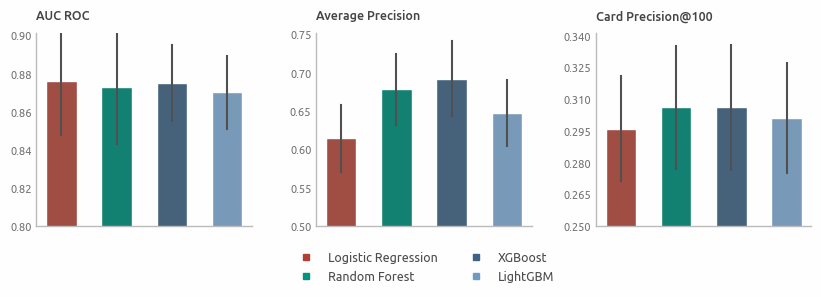


Image 'performance_metrics.png' successfully saved into 'img' directory


In [17]:
plot_metrics(
    data=results,
    metrics=metrics,
    models_list=models_list,
    palette=colors,
    figsize=(10, 2.5),
    limits_list=[[0.800, 0.901, 0.020],
                 [0.500, 0.751, 0.050],
                 [0.250, 0.341, 0.015]],
    save=True,
    filename='performance_metrics'
);

### ROC and PR Curves - Threshold-based Metrics

#### Load Data

In [18]:
ev_start = '2022-10-17'
ev_end = '2022-11-06'

In [19]:
data = read_from_files(
    DIR_INPUT = './data-transformed/',
    BEGIN_DATE = ev_start,
    END_DATE = ev_end
)

#### Remove Defrauded ID of Train and Delay-1 Period from Test Dataset

In [20]:
delta = 7

ev_start = dt.datetime.strptime('2022-10-17', '%Y-%m-%d')

time_train_st = ev_start
time_delay_st = time_train_st + dt.timedelta(days=delta)
time_test_st = time_train_st + dt.timedelta(days=2*delta)

In [21]:
time_train_st, time_delay_st, time_test_st

(datetime.datetime(2022, 10, 17, 0, 0),
 datetime.datetime(2022, 10, 24, 0, 0),
 datetime.datetime(2022, 10, 31, 0, 0))

In [22]:
train = data.loc[data['tx_datetime'] < time_delay_st, :]
delay = data.loc[(data['tx_datetime'] > time_delay_st)
                & (data['tx_datetime'] < time_test_st), :]
test = data.loc[data['tx_datetime'] > time_test_st, :]

In [23]:
test.shape

(68154, 23)

In [24]:
day_delay_st = int(delay.loc[delay.index[0], 'tx_time_days'])
day_delay_fin = int(delay.loc[delay.index[-1], 'tx_time_days'])

In [25]:
defrauded_train_df = train.loc[train['tx_fraud']==1, :]
defrauded_train_arr = defrauded_train_df['customer_id'].unique()

In [26]:
loc = (delay['tx_time_days'].between(day_delay_st, day_delay_fin-1) &
       (delay['tx_fraud'] == 1))

defrauded_delay_df = delay.loc[loc, :]
defrauded_delay_arr = defrauded_delay_df['customer_id'].unique()

In [27]:
defrauded_arr = np.append(defrauded_train_arr, defrauded_delay_arr)
defrauded_arr = np.unique(defrauded_arr)

In [28]:
defrauded_arr[-5:]

array([4978, 4982, 4989, 4990, 4994])

In [29]:
test = test.loc[~test['customer_id'].isin(defrauded_arr), :]

In [30]:
test.shape

(57443, 23)

#### Train-Predict Models for Curves

In [31]:
hyper_dict['LightGBM'].update({'verbose':-1})

In [32]:
lr = LogisticRegression(**hyper_dict['Logistic Regression'])
rf = RandomForestClassifier(**hyper_dict['Random Forest'])
xgb = XGBClassifier(**hyper_dict['XGBoost'])
lgb = LGBMClassifier(**hyper_dict['LightGBM'])

In [33]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', lr)
])

In [34]:
lr_pipe.fit(train[features], train[target])

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LogisticRegression(C=1, max_iter=5000, random_state=42,
                                    solver='saga'))])

In [35]:
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', rf)
])

In [36]:
rf_pipe.fit(train[features], train[target])

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 RandomForestClassifier(max_depth=25, n_estimators=150,
                                        random_state=42))])

In [37]:
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', xgb)
])

In [38]:
xgb_pipe.fit(train[features], train[target])

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [39]:
lgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', lgb)
])

In [40]:
lgb_pipe.fit(train[features], train[target])

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, n_estimators=150, random_state=42,
                                verbose=-1))])

In [41]:
y_true = test['tx_fraud'].values

In [42]:
lr_score = lr_pipe.predict(test[features])
rf_score = rf_pipe.predict(test[features])
xgb_score = xgb_pipe.predict(test[features])
lgb_score = lgb_pipe.predict(test[features])

In [43]:
lr_score_prob = lr_pipe.predict_proba(test[features])
rf_score_prob = rf_pipe.predict_proba(test[features])
xgb_score_prob = xgb_pipe.predict_proba(test[features])
lgb_score_prob = lgb_pipe.predict_proba(test[features])

#### Curves

In [44]:
y_score_prob_list = [
    lr_score_prob[:, 1], rf_score_prob[:, 1],
    xgb_score_prob[:, 1], lgb_score_prob[:, 1]
]

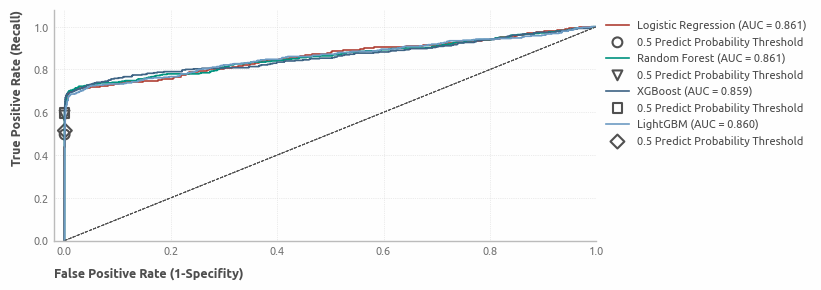


Image 'roc_curve.png' successfully saved into 'img' directory


In [184]:
plot_roc_curve(
    y_true, y_score_prob_list, models_list, (7, 3),
    colors, save=True, filename='roc_curve'
)

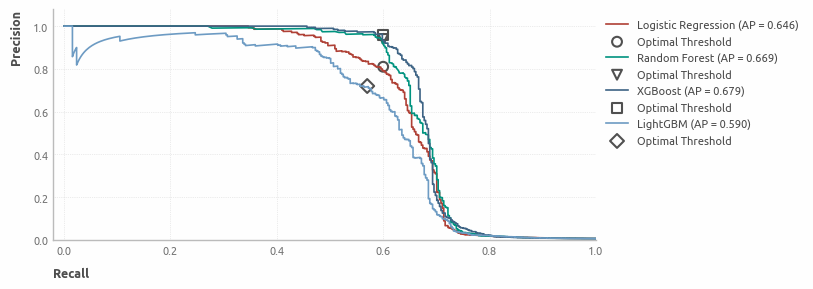


Image 'pr_curve.png' successfully saved into 'img' directory


In [185]:
threshold_opt_list = plot_prec_rec(
    y_true, y_score_prob_list, models_list, (7, 3),
    colors, save=True, filename='pr_curve')

#### Threshold

In [47]:
threshold_opt_df = pd.DataFrame(
    columns={
        'index': [],
        'Precision': [],
        'Recall': [],
        'Threshold': []
    }
)

for i, j in zip(models_list, threshold_opt_list):
    
    threshold_opt_df.loc[len(threshold_opt_df)] = [i] + j

threshold_opt_df = threshold_opt_df.set_index('index', drop=True)
threshold_opt_df.index.name = None

In [48]:
# по F1-score
threshold_opt_df

,Precision,Recall,Threshold
Logistic Regression,0.81,0.60,0.19
Random Forest,0.94,0.60,0.39
XGBoost,0.96,0.60,0.49
LightGBM,0.72,0.57,0.30


In [49]:
threshold_xgb_opt = threshold_opt_df.loc['XGBoost', 'Threshold']

In [50]:
xgb_score_opt = (xgb_score_prob[:, 1] >= threshold_xgb_opt)

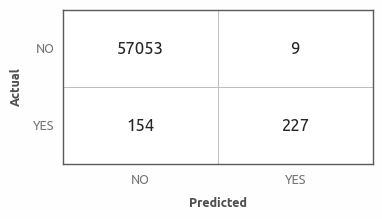


Image 'confmatrix_xgb_thresh.png' successfully saved into 'img' directory


In [51]:
conf_xgb = conf_matrix(
               y_true,
               xgb_score_opt,
               save=True,
               filename='confmatrix_xgb_thresh'
           )

In [52]:
conf_xgb

(57053, 9, 154, 227)

In [53]:
sum(conf_xgb)

57443

In [54]:
sum([conf_xgb[2], conf_xgb[3]])

381

In [55]:
total_transactions = sum(conf_xgb)
total_frauds = sum([conf_xgb[2], conf_xgb[3]])
fp_opt = conf_xgb[1]
fn_opt = conf_xgb[2]
tp_opt = conf_xgb[3]
tn_opt = conf_xgb[0]

In [56]:
total_transactions

57443

In [57]:
total_frauds

381

In [58]:
total_frauds / total_transactions * 100

0.6632661943143638

In [59]:
fn_opt

154

In [60]:
fp_opt

9

In [61]:
tp_opt

227

In [62]:
fp_opt + tp_opt

236

In [63]:
prec_opt = tp_opt / (fp_opt + tp_opt)

In [64]:
prec_opt

0.961864406779661

In [65]:
rec_opt = tp_opt / (tp_opt + fn_opt)

In [66]:
rec_opt

0.5958005249343832

In [67]:
threshold_range_xgb = threshold_range(
    y_true, xgb_score_prob,
    lower=0, upper=1, step=0.05, kind='prob')

In [68]:
threshold_range_xgb.head()

,Threshold,Precision,Recall,F1-score,FP,FN,TP,TN
0,0.00,0.01,1.00,0.01,57062,0,381,0
1,0.05,0.70,0.67,0.69,107,126,255,56955
2,0.10,0.83,0.64,0.72,50,136,245,57012
3,0.15,0.87,0.63,0.73,35,141,240,57027
4,0.20,0.90,0.62,0.74,27,143,238,57035


In [69]:
threshold_range_xgb_plot = threshold_range_xgb[[
    'Threshold', 'Precision', 'Recall', 'F1-score'
]]

In [70]:
threshold_range_xgb_plot = data_smoothing(
    data=threshold_range_xgb_plot,
    x_var='Threshold',
    y_vars=['Precision', 'Recall', 'F1-score'],
    k=3, smooth_num=100
)

In [71]:
threshold_range_xgb_plot = pd.melt(
    frame=threshold_range_xgb_plot,
    id_vars='Threshold',
    value_vars=['Precision', 'Recall', 'F1-score'],
    var_name='Metric',
    value_name='Value'
)

In [72]:
threshold_opt_df

,Precision,Recall,Threshold
Logistic Regression,0.81,0.60,0.19
Random Forest,0.94,0.60,0.39
XGBoost,0.96,0.60,0.49
LightGBM,0.72,0.57,0.30


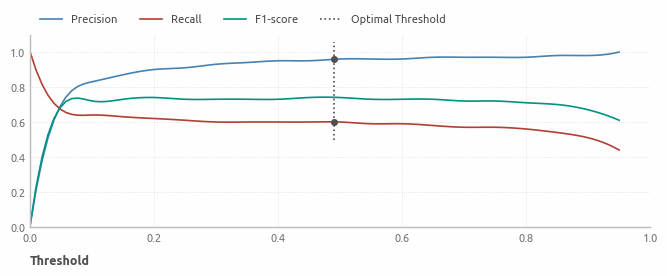


Image 'pr_tradeoff_plot.png' successfully saved into 'img' directory


In [73]:
fig = plt.figure()

sns.lineplot(
    data=threshold_range_xgb_plot,
    x='Threshold',
    y='Value',
    hue='Metric',
    palette=[palette[0], palette[1], palette[2]]
)

# coordinates of optimal points
x_opt = threshold_opt_df.loc['XGBoost','Threshold']
y_opt_prec = threshold_opt_df.loc['XGBoost', 'Precision']
y_opt_rec = threshold_opt_df.loc['XGBoost', 'Recall']

sns.scatterplot(
    x=[x_opt],
    y=[y_opt_prec],
    marker='.',
    s=50,
    color=palette[-1],
    edgecolor=palette[-1],
    linewidth=1.5,
    zorder=10
)

sns.scatterplot(
    x=[x_opt],
    y=[y_opt_rec],
    marker='.',
    s=50,
    color=palette[-1],
    edgecolor=palette[-1],
    linewidth=1.5,
    zorder=10
)

# optimal lines
x_opt_line = [x_opt, x_opt]
y_opt_line = [y_opt_rec-0.1, y_opt_prec+0.1]

plt.plot(
    x_opt_line, y_opt_line, 
    label='Optimal Threshold',
    color=palette[-1], linestyle=':')

# for legend label 'Optimal Threshold'
sns.lineplot(
    x=x_opt,
    y=(0.59,0.61),
    linewidth=0.1,
    linestyle=':',
    color=palette[-1]
)

plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.ylabel(None)

# plt.legend(
#     labels=None, loc='upper right',
#     bbox_to_anchor=(1.29, 1), prop={'size': 9}, labelcolor='0.3'
# )

plt.legend(**legend_inline, ncols=4)
plt.show()

savefig('pr_tradeoff_plot')

In [74]:
fp_list = []
fn_list = []

range = np.arange(1, 0, -0.01)

for threshold in range:

    xgb_score_thresh = xgb_score_prob[:, 1]>=threshold
    matrix = confusion_matrix(y_true, xgb_score_thresh)
    
    fp = matrix[0][1]
    fn = matrix[1][0]

    fp_list.append(fp)
    fn_list.append(fn)

In [75]:
tradeof_df = pd.DataFrame(
    data={
        'False Fraud Predictions': fp_list,
        'Missed Fraud Transactions': fn_list,
    }
)

In [76]:
tradeof_df = tradeof_df.drop_duplicates('False Fraud Predictions')

tradeof_df_plot = data_smoothing(
    data=tradeof_df,
    x_var='False Fraud Predictions',
    y_vars=['Missed Fraud Transactions'],
    k=2, smooth_num=100
)

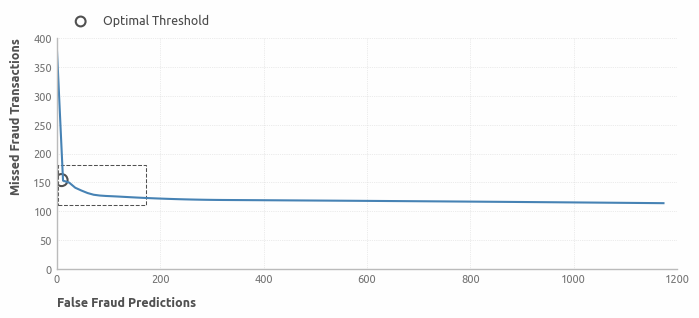


Image 'missedwrong_tradeoff_1.png' successfully saved into 'img' directory


In [77]:
fig = plt.figure(figsize=(8, 3))

sns.lineplot(
    data=tradeof_df_plot,
    x='False Fraud Predictions',
    y='Missed Fraud Transactions',
    linewidth=1.5
);

sns.scatterplot(
    x=[fp_opt],
    y=[fn_opt],
    marker='o',
    s=75,
    edgecolor=palette[-1],
    facecolor='None',
    linewidth=1.5,
    label='Optimal Threshold'
)

currentAxis = plt.gca()
currentAxis.add_patch(
    Rectangle(
        xy=(3, 110),
        width=170,
        height=70,
        edgecolor=palette[-1],
        facecolor='none',
        linestyle='--',
        linewidth=0.75)
)

xmax = tradeof_df_plot['False Fraud Predictions'].max()
ymax = tradeof_df_plot['Missed Fraud Transactions'].max()

plt.ylim(0, ymax+19)
plt.xlim(0, xmax+26)
plt.xlabel('False Fraud Predictions')
plt.ylabel('Missed Fraud Transactions')

# plt.legend(
#     labels=None, loc='upper right',
#     bbox_to_anchor=(1.28, 1), prop={'size': 9}, labelcolor='0.3'
# )

lgnd = plt.legend(**legend_inline, fontsize=9)

for handle in lgnd.legend_handles:
    handle.set_sizes([50.0])
    handle.set_linewidth([1.5])

plt.show()

savefig('missedwrong_tradeoff_1')

In [78]:
fp_list_1 = []
fn_list_1 = []

range = np.arange(0.01, 1, 0.01)

for threshold in range:

    xgb_score_thresh = (xgb_score_prob[:, 1] >= threshold)
    matrix = confusion_matrix(y_true, xgb_score_thresh)
    
    fp_1 = matrix[0][1]
    fn_1 = matrix[1][0]

    fp_list_1.append(fp_1)
    fn_list_1.append(fn_1)

In [79]:
tradeof_df_1 = pd.DataFrame(
    data={
        'False Fraud Predictions': fp_list_1,
        'Missed Fraud Transactions': fn_list_1,
    }
)

In [80]:
tradeof_df_1 = tradeof_df_1.drop_duplicates('False Fraud Predictions')
tradeof_df_1 = tradeof_df_1.sort_values('False Fraud Predictions')

tradeof_df_plot_1 = data_smoothing(
    data=tradeof_df_1[:-1],
    x_var='False Fraud Predictions',
    y_vars=['Missed Fraud Transactions'],
    k=3, smooth_num=300
)


Image 'missedwrong_tradeoff_2.png' successfully saved into 'img' directory


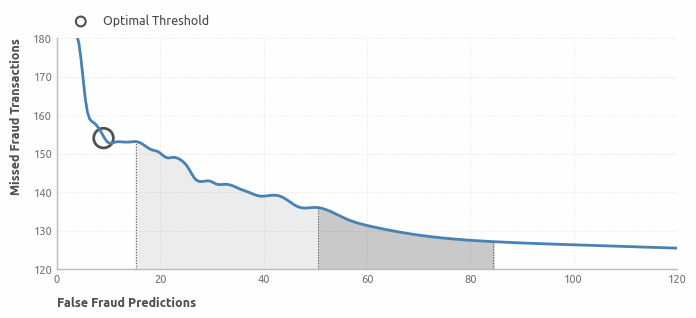

In [81]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(
    smoothed(tradeof_df_plot_1['False Fraud Predictions'], n=1000),
    smoothed(tradeof_df_plot_1['Missed Fraud Transactions'], n=1000),
    linewidth=2,
    color=palette[0],
    alpha=1
);

line = ax.get_lines()
x_values =  line[0].get_xdata()
y_values = line[0].get_ydata()

condition_1 = ((15<=x_values) & (x_values<=50.8))
condition_2 = ((50.5<=x_values) & (x_values<=84.8))

ax.fill_between(
    x=x_values,
    y1=y_values,
    where=condition_1,
    linewidth=0,
    color=palette[-1], alpha=0.1
)

ax.fill_between(
    x=x_values,
    y1=y_values,
    where=condition_2,
    linewidth=0,
    color=palette[-1], alpha=0.3
)

sns.scatterplot(
    x=[fp_opt],
    y=[fn_opt],
    marker='o',
    s=200,
    edgecolor=palette[-1],
    facecolor='None',
    linewidth=2,
    label='Optimal Threshold'
)

plt.plot(
    [15.2,15.2], [120,153],
    linestyle=':', linewidth=0.75, color=palette[-1])

plt.plot(
    [50.5,50.5], [120,136],
    linestyle=':', linewidth=0.75, color=palette[-1])

plt.plot(
    [84.3,84.3], [120,127],
    linestyle=':', linewidth=0.75, color=palette[-1])

plt.ylim(120, 180)
plt.xlim(0, 120)

plt.xlabel('False Fraud Predictions')
plt.ylabel('Missed Fraud Transactions')

# lgnd = plt.legend(
#     labels=None, loc='upper right',
#     bbox_to_anchor=(1.28, 1), prop={'size': 9}, labelcolor='0.3')

lgnd = plt.legend(**legend_inline, fontsize=9)

for handle in lgnd.legend_handles:
    handle.set_sizes([50.0])
    handle.set_linewidth([1.5])

savefig('missedwrong_tradeoff_2')

plt.show()

In [82]:
47 - 15

32

In [83]:
153 - 136

17

In [84]:
32 / 17

1.8823529411764706

In [85]:
86 - 47

39

In [86]:
136 - 127

9

In [87]:
39 / 9

4.333333333333333

In [88]:
thresh_search = threshold_range(
    y_true, xgb_score_prob,
    lower=0, upper=0.5, step=0.005, kind='prob')

In [89]:
thresh_search.loc[thresh_search['FP']==86, :]

,Threshold,Precision,Recall,F1-score,FP,FN,TP,TN
12,0.06,0.75,0.67,0.7,86,127,254,56976


In [90]:
thresh_search.loc[thresh_search['FP']==47, :]

,Threshold,Precision,Recall,F1-score,FP,FN,TP,TN
22,0.11,0.84,0.64,0.73,47,136,245,57015


In [91]:
thresh_search.loc[thresh_search['FP']==15, :]

,Threshold,Precision,Recall,F1-score,FP,FN,TP,TN
70,0.350,0.94,0.6,0.73,15,153,228,57047
71,0.355,0.94,0.6,0.73,15,153,228,57047
72,0.360,0.94,0.6,0.73,15,153,228,57047
73,0.365,0.94,0.6,0.73,15,153,228,57047


### Card Precision@100

In [92]:
xgb_score_prob_fraud = xgb_score_prob[:, 1]

In [93]:
card_prec_df = test.copy()

In [94]:
card_prec_df['tx_fraud_prob'] = xgb_score_prob_fraud
card_prec_df['predictions'] = xgb_score_prob_fraud

In [95]:
cp_mean_week = card_precision_top_k(card_prec_df, 100)[2]

In [96]:
cp_mean_week

0.30428571428571427

In [97]:
card_prec_df = card_prec_df.drop('predictions', axis=1)

In [98]:
card_prec_df['tx_fraud_score'] = card_prec_df['tx_fraud_prob']>=0.5
card_prec_df['tx_fraud_score'] = card_prec_df['tx_fraud_score'].astype(int)

In [99]:
card_prec_df_day = card_prec_df.loc[card_prec_df['tx_time_days']==182, :]

In [100]:
card_prec_df_day.shape

(8267, 25)

In [101]:
fraud_transactions_day = card_prec_df_day['tx_fraud'].sum()

In [102]:
fraud_transactions_day

54

In [103]:
fraud_transactions_day / len(card_prec_df_day) * 100

0.6531994677633967

In [104]:
card_prec_df_day = (card_prec_df_day
                    .groupby('customer_id')
                    .max()
                    .sort_values('tx_fraud_prob', ascending=False)
                    .reset_index())

In [105]:
card_prec_df_day.shape

(3203, 25)

In [106]:
fraud_cards_day = card_prec_df_day['tx_fraud'].sum()

In [107]:
fraud_cards_day

51

In [108]:
fraud_cards_day / len(card_prec_df_day) * 100

1.5922572588198562

In [109]:
card_prec_df_day = (card_prec_df_day
                    .sort_values('tx_fraud_prob', ascending=False))

In [110]:
card_prec_df_top100 = card_prec_df_day.iloc[:100, :]

In [111]:
fraud_cards_day_score = card_prec_df_top100['tx_fraud_score'].sum()

In [112]:
fraud_cards_day_score

30

In [113]:
cp_day = fraud_cards_day_score / 100

In [114]:
cp_day

0.3

In [115]:
cp_day_max = fraud_cards_day / 100

In [116]:
cp_day_max

0.51

In [117]:
fraud_cards_day_score / fraud_cards_day

0.5882352941176471

In [118]:
fraud_cards_day_missed = card_prec_df_top100[
    card_prec_df_top100['tx_fraud'] != card_prec_df_top100['tx_fraud_score']
]

In [119]:
fraud_cards_day_missed_num = len(fraud_cards_day_missed)

In [120]:
fraud_cards_day_missed_num

5

In [121]:
5 / 35

0.14285714285714285

In [122]:
matrix = confusion_matrix(
    card_prec_df_top100['tx_fraud'], card_prec_df_top100['tx_fraud_score']
)

In [123]:
matrix

array([[65,  0],
       [ 5, 30]])

In [124]:
matrix[0][0]

65

In [125]:
out_of_top100_frauds = (fraud_cards_day
                        - fraud_cards_day_score
                        - fraud_cards_day_missed_num)

In [126]:
out_of_top100_frauds

16

In [127]:
plot_df = pd.DataFrame({   
    '': ['Top 100 Suspicious Transactions'],
    'Out of Top-100: False Negative': [-out_of_top100_frauds],
    'In Top-100: True Negative': [matrix[0][0]],
    'In Top-100: False Negative': [matrix[1][0]],
    'In Top-100: True Positive': [matrix[1][1]]
})

plot_df = plot_df.set_index('')
plot_df.index.name = None

In [128]:
plot_df

,Out of Top-100: False Negative,In Top-100: True Negative,In Top-100: False Negative,In Top-100: True Positive
Top 100 Suspicious Transactions,-16,65,5,30



Image 'cp_100.png' successfully saved into 'img' directory


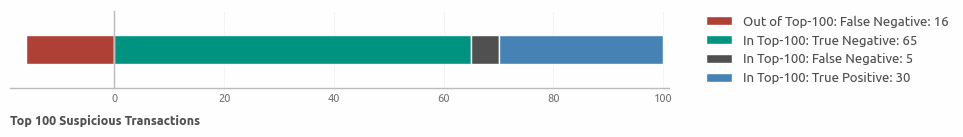

In [129]:
fig, ax = plt.subplots()

plot_df.plot(
    kind='barh', stacked='True', width=0.3, figsize=(8.5,1),
    color=[palette[1], palette[2], palette[-1], palette[0]], ax=ax)

ax.spines['left'].set_position('zero')

out = plot_df['Out of Top-100: False Negative'].item()
top_correct_clean = plot_df['In Top-100: True Negative'].item()
top_missed = plot_df['In Top-100: False Negative'].item()
top_correct_fraud = plot_df['In Top-100: True Positive'].item()

labels = [
    'Out of Top-100: False Negative: {0}'.format(abs(out)),
    'In Top-100: True Negative: {0}'.format(top_correct_clean),
    'In Top-100: False Negative: {0}'.format(top_missed),
    'In Top-100: True Positive: {0}'.format(top_correct_fraud)
]

plt.legend(
    labels=labels, loc='center', bbox_to_anchor=(1.24, 0.5),
    prop={'size': 9.5}, labelcolor='0.3')

xlabel = 'Top 100 Suspicious Transactions'

plt.yticks([])
plt.xlabel(xlabel)
plt.xlim(-19,101)

# plt.savefig(
#     fname='img/{}.png'.format('cp_100'),
#     bbox_inches='tight')

savefig('cp_100')

plt.show()

In [130]:
card_prec_comp_df_xgb = performance_xgb_base.loc[
    performance_xgb_base['Parameters summary'].isin(['10/6/0.3']), :]

card_prec_comp_df_xgb = card_prec_comp_df_xgb[[
    'Parameters summary',
    'Card Precision@100 Test',
    'Card Precision@100 Test Std',
    'Card Precision@100 Validation',
    'Card Precision@100 Validation Std'
]]

card_prec_comp_df_xgb = (card_prec_comp_df_xgb
                        .sort_values('Card Precision@100 Validation',
                                     ascending=False))

In [131]:
card_prec_comp_df_xgb

,Parameters summary,Card Precision@100 Test,Card Precision@100 Test Std,Card Precision@100 Validation,Card Precision@100 Validation Std
29,10/6/0.3,0.302143,0.017742,0.321429,0.016225


In [132]:
card_prec_comp_df_rf = performance_rf_base.loc[
    performance_rf_base['Parameters summary'].isin(['150/50']), :]

card_prec_comp_df_rf = card_prec_comp_df_rf[[
    'Parameters summary',
    'Card Precision@100 Test',
    'Card Precision@100 Test Std',
    'Card Precision@100 Validation',
    'Card Precision@100 Validation Std'
]]

card_prec_comp_df_rf = (card_prec_comp_df_rf
                        .sort_values('Card Precision@100 Validation',
                                     ascending=False))

In [133]:
card_prec_comp_df_rf

,Parameters summary,Card Precision@100 Test,Card Precision@100 Test Std,Card Precision@100 Validation,Card Precision@100 Validation Std
20,150/50,0.305714,0.018708,0.321071,0.018193


In [134]:
card_prec_comp_df = pd.concat(
    [card_prec_comp_df_xgb, card_prec_comp_df_rf], axis=0)

card_prec_comp_df.iloc[0,0] = 'XGBoost'
card_prec_comp_df.iloc[1,0] = 'Random Forest'

In [135]:
card_prec_comp_df

,Parameters summary,Card Precision@100 Test,Card Precision@100 Test Std,Card Precision@100 Validation,Card Precision@100 Validation Std
29,XGBoost,0.302143,0.017742,0.321429,0.016225
20,Random Forest,0.305714,0.018708,0.321071,0.018193


In [136]:
card_prec_comp_df_primary = card_prec_comp_df[[
    'Parameters summary',
    'Card Precision@100 Validation',
    'Card Precision@100 Test'
]]

card_prec_comp_df_primary.columns = [
    'Parameters summary',
    'Validation',
    'Test'
]

card_prec_comp_df_primary = pd.melt(
    frame=card_prec_comp_df_primary,
    id_vars='Parameters summary',
    value_vars=['Validation', 'Test'],
    var_name='',
    value_name='Card Precision@100'
)

In [137]:
card_prec_comp_df_primary

,Parameters summary,,Card Precision@100
0,XGBoost,Validation,0.321429
1,Random Forest,Validation,0.321071
2,XGBoost,Test,0.302143
3,Random Forest,Test,0.305714


In [138]:
card_prec_comp_df_std = card_prec_comp_df.copy()

In [139]:
card_prec_comp_df_std

,Parameters summary,Card Precision@100 Test,Card Precision@100 Test Std,Card Precision@100 Validation,Card Precision@100 Validation Std
29,XGBoost,0.302143,0.017742,0.321429,0.016225
20,Random Forest,0.305714,0.018708,0.321071,0.018193


In [140]:
card_prec_comp_df['Card Precision@100 Test Conf Min'] = \
    (card_prec_comp_df['Card Precision@100 Test']
     - 3.18*(card_prec_comp_df['Card Precision@100 Test Std']/4**0.5))

card_prec_comp_df['Card Precision@100 Test Conf Max'] = \
    (card_prec_comp_df['Card Precision@100 Test']
     + 3.18*(card_prec_comp_df['Card Precision@100 Test Std']/4**0.5))

card_prec_comp_df['Card Precision@100 Validation Conf Min'] = \
    (card_prec_comp_df['Card Precision@100 Validation']
     - 3.18*(card_prec_comp_df['Card Precision@100 Validation Std']/4**0.5))

card_prec_comp_df['Card Precision@100 Validation Conf Max'] = \
    (card_prec_comp_df['Card Precision@100 Validation']
     + 3.18*(card_prec_comp_df['Card Precision@100 Validation Std']/4**0.5))

In [141]:
cp_model_loc = card_prec_comp_df['Parameters summary'] == 'XGBoost'

cp_model_test_ymin = (card_prec_comp_df
                      .loc[cp_model_loc, 'Card Precision@100 Test Conf Min']
                      .values[0])
cp_model_test_ymax = (card_prec_comp_df
                      .loc[cp_model_loc, 'Card Precision@100 Test Conf Max']
                      .values[0])
cp_model_valid_ymin = (card_prec_comp_df
                       .loc[cp_model_loc, 'Card Precision@100 Validation Conf Min']
                       .values[0])
cp_model_valid_ymax = (card_prec_comp_df
                       .loc[cp_model_loc, 'Card Precision@100 Validation Conf Max']
                       .values[0])

In [142]:
auc_model_loc = card_prec_comp_df['Parameters summary'] == 'Random Forest'

auc_model_test_ymin = (card_prec_comp_df
                       .loc[auc_model_loc, 'Card Precision@100 Test Conf Min']
                       .values[0])
auc_model_test_ymax = (card_prec_comp_df
                       .loc[auc_model_loc, 'Card Precision@100 Test Conf Max']
                       .values[0])
auc_model_valid_ymin = (card_prec_comp_df
                        .loc[auc_model_loc, 'Card Precision@100 Validation Conf Min']
                        .values[0])
auc_model_valid_ymax = (card_prec_comp_df
                        .loc[auc_model_loc, 'Card Precision@100 Validation Conf Max']
                        .values[0])

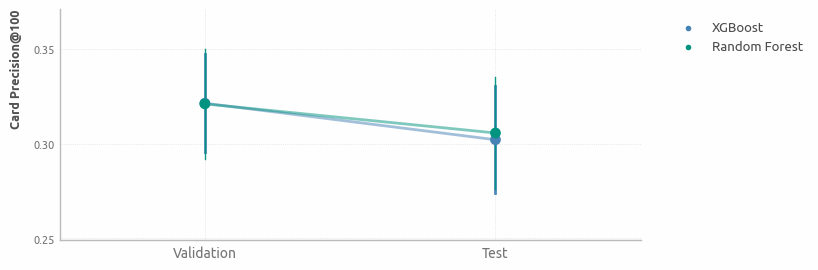

In [143]:
plt.figure(figsize=(7.5,3))

sns.scatterplot(
    data=card_prec_comp_df_primary,
    x='',
    y='Card Precision@100',
    hue='Parameters summary',
    s=60,
    palette=[palette[0], palette[2]],
    edgecolor='None',
    zorder=100,
    alpha=1
)

sns.lineplot(
    data=card_prec_comp_df_primary,
    x='',
    y='Card Precision@100',
    hue='Parameters summary',
    legend=None,
    palette=[palette[0], palette[2]],
    linewidth=2,
    alpha=0.5
)

# cp conf plot
plt.plot(
    ['Validation', 'Validation'],
    [cp_model_valid_ymin, cp_model_valid_ymax],
    color=palette[0],
    linewidth=2,
    alpha=0.95,
)

plt.plot(
    ['Test', 'Test'],
    [cp_model_test_ymin, cp_model_test_ymax],
    color=palette[0],
    linewidth=2,
    alpha=0.95
)

# auc conf plot
plt.plot(
    ['Validation', 'Validation'],
    [auc_model_valid_ymin, auc_model_valid_ymax],
    color=palette[2],
    linewidth=1,
    alpha=0.95
)

plt.plot(
    ['Test', 'Test'],
    [auc_model_test_ymin, auc_model_test_ymax],
    color=palette[2],
    linewidth=1,
    alpha=0.95
)

plt.xticks(fontsize=10)
plt.xlim(-0.5,1.5)
plt.ylim(0.249, 0.371)
plt.yticks(np.arange(0.250, 0.371, 0.05))

plt.legend(
    loc='upper right', bbox_to_anchor=(1.3,1),
    prop={'size': 9.5}, labelcolor='0.3')

plt.savefig(
    fname='img/{}.png'.format('cp_roc_auc_models'),
    bbox_inches='tight'
)

plt.show()

### Executing Times


Image 'score_time.png' successfully saved into 'img' directory


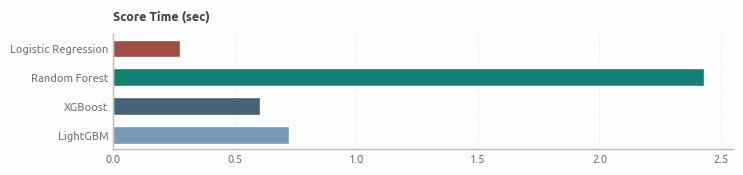

In [144]:
plot_times(
    data=results,
    times=['Score Time'],
    palette=colors,
    figsize=(8,1.5),
    save=True, filename='score_time'
)


Image 'fit_hyper_time.png' successfully saved into 'img' directory


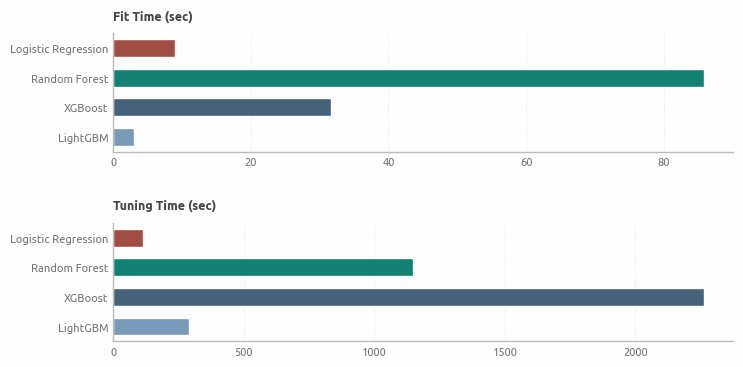

In [145]:
plot_times(
    data=results,
    times=['Fit Time', 'Tuning Time'],
    palette=colors,
    figsize=(8,4),
    save=True, filename='fit_hyper_time'
)

### Save Session

In [146]:
save_session(dir_save)

### Executing time

In [147]:
e_time = str(dt.timedelta(seconds=np.round(time.time() - t_script)))
print('Execution time: {}'.format(e_time))

Execution time: 0:01:26
